### Deep Learning Supervised Text Classification
- BiLSTM (transformer-based data augmentation)

Bidirectional recurrent neural networks (RNN) put two independent RNNs together. This structure allows the networks to have both backward and forward information about the sequence at every time step


### Prepare Environment

In [27]:
from numpy.random import seed
seed(156)
import tensorflow as tf
tf.random.set_seed(256)

In [28]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [29]:
%cd /content/drive/MyDrive/Colab_Notebooks/safety_report_tc

/content/drive/MyDrive/Colab_Notebooks/safety_report_tc


In [30]:
# Importing required libraries
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tqdm.std import tqdm
from IPython.display import display, HTML
import time
import textwrap
import json
import datetime

### Load Data

In [31]:
# Pick a minority category of interest (base data from source)
focus_cats = [
    'hydraulic fluid or oil leak',
    'line strike',
    'site compliance or practice issue',
    'ppe non-compliance',
    'mechanical or equipment issue'
    ]

fns = [
    '2209031206', # hydraulic fluid or oil leak
    '2210031444', # line strike
    '2210031122', # site compliance or practice issue
    '2210031323', # ppe non-compliance
    '2210032046' # Mechanical or equipment issue
]

fn_aug_names = [
    'hydraulic fluid or oil leak_7920_trda',
    'line strike_8316_trda',
    'site compliance or practice issue_8410_trda',
    'ppe non-compliance_8034_trda',
    'mechanical or equipment issue_8064_trda'
]

# Select a category to load
pick = input('Pick a category: ')
index = focus_cats.index(pick)
focus_cat = focus_cats[index]
fn = fns[index]
fn = f'01_data/prepared/{fn}_prepared_{focus_cat}_data.csv'

# Load data from a minority category of interest
df = pd.read_csv(fn)
df = df[['text', 'category']]
df = pd.read_csv(fn)
df

Pick a category: line strike


,text,category
0,foreign body entered employee l eye while grin...,0
1,drainage pipe damaged at two two m depth see s...,0
2,robodrill spider excavator being operated when...,0
3,pressure hose made contact with light fitting ...,0
4,nacap 30t hitachi hyd hose split resultong in ...,0
...,...,...
93852,fall on water vehicle an employee was using an...,0
93853,other fall to lower level unspecified an emplo...,0
93854,injured by slipping or swinging object held by...,0
93855,direct exposure to electricity greater than tw...,0


### Data Preparation (Train / Test Splits)

In [32]:
# Now create the input to the model training stage
X = df.text
y = df.category # Remember, these are not necessarily the 'truth' but rule_book hits

# Apply a simple 80/20 split
# TODO - The dataset is heavily imbalanced. Treat this appropriately.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1234)

In [33]:
base_train_count = len(X_train)
base_train_count

75085

In [34]:
test_trues = list(y_test[y_test==1].index.values)
test_trues.sort()
print('Test:', len(test_trues), test_trues)

train_trues = list(y_train[y_train==1].index.values)
train_trues.sort()
print('Train:', len(train_trues), train_trues)

Test: 62 [819, 1559, 1779, 2042, 2243, 2546, 2557, 3180, 3471, 3497, 3609, 3661, 4435, 5068, 5999, 6704, 7729, 7905, 8081, 8504, 8792, 9378, 9415, 9703, 9870, 9893, 9935, 10113, 10698, 12444, 12798, 13145, 14488, 14509, 17206, 17367, 17477, 17630, 18430, 18441, 18881, 18902, 18911, 19339, 20728, 21007, 21357, 22261, 22401, 22636, 22831, 22913, 26529, 30086, 40394, 43621, 67311, 78441, 78526, 80754, 86830, 93268]
Train: 264 [285, 289, 333, 511, 791, 824, 871, 999, 1252, 1334, 1361, 1582, 1610, 1621, 1675, 1677, 1681, 1746, 1755, 1786, 1798, 1804, 1952, 1971, 1984, 2025, 2033, 2067, 2070, 2168, 2210, 2276, 2303, 2337, 2377, 2457, 2492, 2614, 2617, 2674, 3016, 3046, 3114, 3355, 3357, 3381, 3434, 3469, 3579, 3644, 3688, 3701, 3706, 3777, 3974, 3997, 4061, 4141, 4535, 4636, 4757, 4910, 5158, 5359, 5470, 5510, 5541, 5576, 5610, 5631, 5670, 5820, 5974, 6114, 6243, 6501, 7736, 7850, 8019, 8031, 8033, 8079, 8102, 8185, 8255, 8359, 8425, 8556, 8746, 8912, 8918, 8922, 8986, 9104, 9110, 9151, 9206

In [35]:
# Look at training 'trues', i.e., rule-book hits
df_train_trues = df.iloc[train_trues]
df_train_trues

,text,category
285,dc cable struck allied fencing employees repor...,1
289,water line strike during drilling operations d...,1
333,mini excavator damaged underground three pvc d...,1
511,soil boring activity aggrevates poor condition...,1
791,it was notice that part of the bank had collap...,1
...,...,...
85446,struck against stationary object or equipment ...,1
86522,other fall to lower level more than thirty fee...,1
89205,direct exposure to electricity greater than tw...,1
91291,indirect exposure to electricity unspecified a...,1


### Transformer Data Augmentation (TrDA)

In [36]:
# Load fabricated reports
fn_name = fn_aug_names[index] 
df_fab = pd.read_csv(f'01_data/fabricated/{fn_name}.csv')
df_fab

,text,group
0,digger burst buried pipe with teeth,line strike
1,digger burst buried pipe while excavating the ...,line strike
2,digger burst buried pipe operator was excavati...,line strike
3,digger burst buried pipe boom struck an employ...,line strike
4,digger burst buried pipe line with an excavato...,line strike
...,...,...
8311,minidigger when excavating struck underground ...,line strike
8312,minidigger when excavating struck underground ...,line strike
8313,minidigger when excavating struck underground ...,line strike
8314,minidigger when excavating struck underground ...,line strike


In [37]:
# Prepare data by augmenting the raw (real) training data
X_train_fab = df_fab.text
X_train_new = X_train.append(X_train_fab)
X_train_list = list(X_train_new)
y_train_list = list(y_train)

df_tmp = pd.DataFrame(X_train_list, columns = ['text'])
y_train_list.extend([1 for i in range(len(X_train_fab))])
df_tmp['category'] = y_train_list
df_tmp

,text,category
0,ip operated air assisted door with left hand w...,0
1,twenty x spiders fell from roof when generator...,0
2,struck by discharged object or substance an em...,0
3,caught in running equipment or machinery n e c...,0
4,caught in running equipment or machinery durin...,0
...,...,...
83396,minidigger when excavating struck underground ...,1
83397,minidigger when excavating struck underground ...,1
83398,minidigger when excavating struck underground ...,1
83399,minidigger when excavating struck underground ...,1


In [38]:
# Shuffle the dataframe
df_tmp = df_tmp.sample(frac=1).reset_index(drop=True)
df_tmp

,text,category
0,struck against moving part of machinery or equ...,0
1,ip stepped on a rock and rolled his ankle ip i...,0
2,struck by swinging or slipping object other th...,0
3,struck by rolling object or equipmentother tha...,0
4,caught in or compressed by equipment or object...,0
...,...,...
83396,theft of generator third incident trespasser e...,0
83397,caught in running equipment or machinery unspe...,0
83398,employees reported gunshots being fired from o...,0
83399,compressed or pinched by shifting objects or e...,0


In [39]:
# Quick visual check of a random sample of 20 (hits)
df_tmp[df_tmp['category']==1].sample(20)

,text,category
19701,dozer ruptered cable incident 31450at approxim...,1
81789,digger contacted culvert swinging through cabl...,1
33389,damaged and cut communication lines employee w...,1
30189,minidigger hit drain line with teeth and stuck...,1
16369,digger struck buried pipe that was connected t...,1
14278,minidigger while excavating made contact with ...,1
51299,dozer came in contact with sewer line the boom...,1
6583,dozer contacted buried pipe with his bucket as...,1
62277,jcb ruptered pipe and severed two employees tw...,1
12351,operartor came in contact with pvc line and ca...,1


## Build Model

In [40]:
# Load modelling building libraries
from keras.layers import Dropout, Dense, Embedding, LSTM, Bidirectional
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.models import Sequential
from sklearn.metrics import matthews_corrcoef, confusion_matrix
from sklearn import metrics
from sklearn.utils import shuffle
from collections import Counter
import numpy as np
import pickle
import matplotlib.pyplot as plt
import warnings
import logging
logging.basicConfig(level=logging.INFO)

In [41]:
# Create a function to prepare model input sequences and embedding dictionary
def prepare_model_input(X_train, X_test, MAX_NB_WORDS=75000, MAX_SEQUENCE_LENGTH=500):
    np.random.seed(7)
    all_text = np.concatenate((X_train, X_test), axis=0)
    all_text = np.array(all_text)

    # Fit tokeniser only on training text
    text = np.array(X_train)
    tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
    tokenizer.fit_on_texts(text)

    # Save the tokenizer as .pkl file
    pickle.dump(tokenizer, open(f'08_output/{time.strftime("%y%m%d%H%M")}_text_tokenizer.pkl', 'wb'))

    # Generate sequences for all text using tokenizer created only on training text
    # This converts the sentence into a sequence of integers, e.g., [2, 4, 5, 7]
    sequences = tokenizer.texts_to_sequences(all_text)

    # Get a list of all words and their sequence numbers
    word_index = tokenizer.word_index

    # Pad out the sequences with zeroes to max sequence length
    all_text = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
    
    # Seperate training sequences from test
    X_train_Glove = all_text[0:len(X_train), ]
    X_test_Glove = all_text[len(X_train):, ]

    # Now gather the embeddings
    # Start with standard GloVe
    ## https://www.google.com/search?client=safari&rls=en&q=glove+embeddings&ie=UTF-8&oe=UTF-8
    embeddings_dict = {}
    f = open("03_embeddings/glove/glove.6B.50d.txt", encoding="utf8")
    for line in f:
        values = line.split()
        word = values[0]
        try:
            coefs = np.asarray(values[1:], dtype='float32')
        except:
            pass
        embeddings_dict[word] = coefs
    f.close()
    print('Total %s word vectors.' % len(embeddings_dict))
    return (X_train_Glove, X_test_Glove, word_index, embeddings_dict)


In [42]:
# Create a function that builds the deep learning model
def build_bilstm(word_index, embeddings_dict, nclasses,  MAX_SEQUENCE_LENGTH=500, EMBEDDING_DIM=50, dropout=0.5, hidden_layer = 3, lstm_node = 32):
    # Initialize a sequential model
    model = Sequential()
    
    # Make the embedding matrix using the embedding_dict
    embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
    for word, i in word_index.items():
        embedding_vector = embeddings_dict.get(word)
        if embedding_vector is not None:
            # words not found in embedding index will be all-zeros.
            if len(embedding_matrix[i]) != len(embedding_vector):
                print("could not broadcast input array from shape", str(len(embedding_matrix[i])),
                      "into shape", str(len(embedding_vector)), " Please make sure your"
                                                                " EMBEDDING_DIM is equal to embedding_vector file ,GloVe,")
                exit(1)
            embedding_matrix[i] = embedding_vector
            
    # Add embedding layer
    print('_words', len(word_index))
    model.add(Embedding(len(word_index) + 1,
                                EMBEDDING_DIM,
                                weights=[embedding_matrix],
                                input_length=MAX_SEQUENCE_LENGTH,
                                trainable=True))
    # Add hidden layers 
    # Default will be 3 layers
    # Default lstm nodel number will be 32
    for i in range(0, hidden_layer):
        # Add a bidirectional lstm layer
        model.add(Bidirectional(LSTM(lstm_node, return_sequences=True, recurrent_dropout=0.2)))

        # Add a dropout layer after each lstm layer
        model.add(Dropout(dropout))

    model.add(Bidirectional(LSTM(lstm_node, recurrent_dropout=0.2)))

    # Attention addition
    #model.add(attention(return_sequences=True))
    
    model.add(Dropout(dropout))

    # Add the fully connected layer with 256 nuerons & Relu activation
    model.add(Dense(256, activation='relu'))

    # Add the output layer with softmax activation (binary output)
    model.add(Dense(nclasses, activation='softmax'))

    # Compile the model using sparse_categorical_crossentropy
    model.compile(loss='sparse_categorical_crossentropy',
                      optimizer='adam',
                      metrics=["categorical_accuracy"])
    return model

In [43]:
X_train = df_tmp.text
y_train = df_tmp.category

print("Preparing model input ...")
X_train_Glove, X_test_Glove, word_index, embeddings_dict = prepare_model_input(X_train, X_test)
print("Done!")

Preparing model input ...
Total 400000 word vectors.
Done!


In [44]:
print("Building Model!")
model = build_bilstm(word_index, embeddings_dict, 2)
model.summary()

Building Model!
_words 66069
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 500, 50)           3303500   
                                                                 
 bidirectional_4 (Bidirectio  (None, 500, 64)          21248     
 nal)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 500, 64)           0         
                                                                 
 bidirectional_5 (Bidirectio  (None, 500, 64)          24832     
 nal)                                                            
                                                                 
 dropout_5 (Dropout)         (None, 500, 64)           0         
                                                                 
 bidirectional_6 (Bidirec

In [45]:
# Quick view of rule_book hits (should represent the focus category)
X_test[y_test == 1].iloc[0]

'contact with hot objects or substances a contracted employee was brought on site to cap off an hdpe methane gas supply line due to leachate coming through the pipe hot leachate one hundred and fifty degrees f released from the pipe and struck an employee who was standing thirty feet away the employee sustained first and second degree burns to the neck chest abdomen and arms that required hospitalization'

### Model Training & Evaluatrion

In [46]:
def get_eval_report(labels, preds):
    mcc = matthews_corrcoef(labels, preds)
    tn, fp, fn, tp = confusion_matrix(labels, preds).ravel()
    precision = (tp)/(tp+fp)
    recall = (tp)/(tp+fn)
    f1 = (2*(precision*recall))/(precision+recall)
    return {
        "mcc": mcc,
        "true positive": tp,
        "true negative": tn,
        "false positive": fp,
        "false negative": fn,
        "precision" : precision,
        "recall" : recall,
        "F1" : f1,
        "accuracy": (tp+tn)/(tp+tn+fp+fn)
    }

def compute_metrics(labels, preds):
    assert len(preds) == len(labels)
    return get_eval_report(labels, preds)

def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string], '')
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()


In [47]:
# Quick view of rule_book hits (should represent the focus category)
X_test[y_test == 1]

86830    contact with hot objects or substances a contr...
8792     concrete kibble bucket handle made contact wit...
18441    skid steer with auger bit attachment drilled i...
9415     120v temporary powerline damaged at approximat...
14509    contractor excavator boom struck overhead line...
                               ...                        
5068     hb2216 failure of hydraulic hose supplying the...
30086    direct exposure to electricity greater than tw...
40394    struck by dislodged flying object particle two...
819      plate compactor was damaged when operator turn...
20728    tie accidentally drilled into steam tracing on...
Name: text, Length: 62, dtype: object

In [48]:
# Reminder of test set breakdown
Counter(y_test)

Counter({0: 18710, 1: 62})

In [49]:
# Verify augmented training set breakdown
Counter(y_train)

Counter({0: 74821, 1: 8580})

In [50]:
# Split training into training and validation data
X_train_vGlove, X_val_Glove, y_vtrain, y_val = train_test_split(X_train_Glove, y_train, test_size = 0.1, stratify=y_train, random_state = 1234)

# Verify stratification
num_pos_vTrain = len(y_vtrain[y_vtrain==1])
print(f'Number of positives in training (val) split: {num_pos_vTrain}')

num_pos_val = len(y_val[y_val==1])
print(f'Number of positives in validation data: {num_pos_val}')

Number of positives in training (val) split: 7722
Number of positives in validation data: 858


Train new model (n) or load existing (l):n
Training for: line strike
Enter epoch number (default is 3): 3
Epoch 1/3
587/587 [==============================] - 1806s 3s/step - loss: 0.0901 - categorical_accuracy: 0.9044 - val_loss: 0.0620 - val_categorical_accuracy: 0.8932
Epoch 2/3
587/587 [==============================] - 1782s 3s/step - loss: 0.0330 - categorical_accuracy: 0.8966 - val_loss: 0.0227 - val_categorical_accuracy: 0.8910
Epoch 3/3
587/587 [==============================] - 1778s 3s/step - loss: 0.0208 - categorical_accuracy: 0.8974 - val_loss: 0.0221 - val_categorical_accuracy: 0.8945


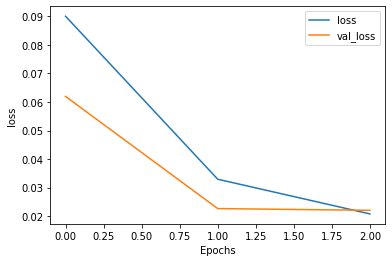

In [51]:
train_or_load = input('Train new model (n) or load existing (l):')
if train_or_load == 'n':
    # Train the model
    print('Training for:', focus_cat)
    epoch_num = int(input('Enter epoch number (default is 3): '))
    history = model.fit(X_train_vGlove, y_vtrain,
                                validation_data=(X_val_Glove, y_val),
                                epochs=epoch_num,
                                batch_size=128,
                                verbose=1)
    
    # Plot training history
    plot_graphs(history, 'loss')
else:
    # load the model from disk
    fname = input('Specify filename (without extension):')
    filename = f'08_output/models/{fname}.pkl'
    model = pickle.load(open(filename, 'rb'))

In [52]:
# Print accuracy measures
print(f'\n Evaluating Model for "{focus_cat}" with {epoch_num} epochs ... \n')

predicted = model.predict(X_test_Glove)
predicted = np.argmax(predicted, axis=1)

print(metrics.classification_report(y_test, predicted))
print("\n")


 Evaluating Model for "line strike" with 3 epochs ... 

587/587 [==============================] - 221s 373ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     18710
           1       0.25      0.48      0.33        62

    accuracy                           0.99     18772
   macro avg       0.63      0.74      0.67     18772
weighted avg       1.00      0.99      0.99     18772





In [53]:
# Create dataframe for inspection of results
tmp = pd.DataFrame(X_test, columns=['text'])
tmp['pred'] = predicted
tmp['rule_book'] = y_test.values

# Quick look at predicted positives
print('Check rule-book hit count: ', len(tmp[tmp['rule_book']==1]))

Check rule-book hit count:  62


In [54]:
# Examine precision stats
# Look at predicted positives that did not have a rule-book hit
table = tmp[(tmp['pred']==1) & (tmp['rule_book']==0)]
table.to_csv(f'10_performance/model_{focus_cat}_bda_fps.csv')
display(HTML(table.to_html()))
total_pos_preds = len(tmp[(tmp['pred']==1)])
total_pos_hits = len(tmp[(tmp['pred']==1) & (tmp['rule_book']==1)])
print(f'\nThere are {len(table)} entries (out of {sum(y_test==1)})...')
print(f'\nTotal no. of positive predictions is  {total_pos_preds}...')
print(f'\nTotal no. of positive hits is  {total_pos_hits }...')

,text,pred,rule_book
15495,employees excavating for fire water line installation next to the sag and ball mill substation using a tlb accidently hooked an earth cable employees excavating for fire water line installation next to the sag and ball mill substation using a tlb accidently hooked an earthing cable work was done under permit however the accompanying drawing had not identified the earthing cable located approximately 200mm below nglvl subcontractor to union steel failed to report the incident the damaged cable was identified during the next shift and reported to hpjv incident stand down was done employees instructed to report incidents supervisor given written warning as he did not report the incident,1,0
6556,"tg1 turbine loss of excitation machine run up with circuit main earth in place incident 30945tg1 turbine loss of excitation machine run up with circuit main earth in placetg1 started evening of wed 1st june identified issues morning of thursday june 2nd incident occurred ten thousand, six hundred and sixteen reported to wgpsn by rsruk two hundred and sixty thousand, seven hundred and sixteen see attached notificationrsruk investigation conducted see attached draft report and slidpack do not have visibility of final versions rsruk have notified wg that they do not require further support for the investigation they will mange any identified actions wg see no value in further action particularly due to the late notification and limited wg involvementin the incidentno damage to generator incurred low potential due to estimated property damage 100k see updated synergi report see detailed description",1,0
18154,"mini excavator blade struck unmarked array post while turning right at intersection on site dirt road at approximately one thousand, two hundred pm on nine million, two hundred and eighty-two thousand and twenty a miniexcavator operator was moving his equipment south on an established gravel road from the parking lot to block four when the incident occurred near pcs six upon coming to a t intersection the operator turned right and made contact with an installed array post with the front blade of the miniexcavator the operator failed to recognize the installed array post in the area and did not utilize a spotter in a congested area around installed array post the operator failed to stop work immediately and moved his excavator down the road clear of traffic he then contacted his direct supervisor and made him aware of the incident one secured the scene and gathered witness two escorted operator to safety office for ua three photography of scene four notification to wood heavy civil hessa management team and gc",1,0
2005,"water being pumped from underground conduit leaked out of subcontractors vacc truck onto ground approximately twenty gallons work was stopped incident 38211at approximately one thousand, five hundred and thirty a subcontractors vacuum truck was used to vacuum particulate water from underground electrical conduit m1 the vacuum was released to switch over to conduit m2 and it was noticed that water was leaking from the back of the debusk vacuum truck the leak was noticed and stopped immediately resulting in approximately twenty gallons of particulate water being released to the ground the water was sampled for ph and determined to be at six see detailed description",1,0
14389,hdpe fire water line ruptured by auger omk were drilling holes to a depth of one 050m for installation of the crusher fencing posts when a one hundred and ten diameter fire water line was accidentally ruptured by the rotating auger attachment this caused the immediate area to flood with water incident immediately reported to hpjv su duty manager fire water line isolated to effect repair of ruptured fire water line scene frozen for investigation purposes requested contractor to hand excavate to identify any other possible lines,1,0
3519,"dozer blade hit twenty-four pipe removing top part of pipe incident 34624at one thousand

In [55]:
# Take a look at predicted negatives that had a rule-book hit
table = tmp[(tmp['pred']==0) & (tmp['rule_book']==1)]
display(HTML(table.to_html()))
print(f'\nThere are {len(table)} entries (out of {sum(y_test==1)})...')


There are 88 entries (out of 62)...

Total no. of positive predictions is  118...

Total no. of positive hits is  30...


,text,pred,rule_book
86830,contact with hot objects or substances a contracted employee was brought on site to cap off an hdpe methane gas supply line due to leachate coming through the pipe hot leachate one hundred and fifty degrees f released from the pipe and struck an employee who was standing thirty feet away the employee sustained first and second degree burns to the neck chest abdomen and arms that required hospitalization,0,1
93268,direct exposure to electricity greater than two hundred and twenty volts on july nine two thousand and twenty-one employees were operating a mobile conveyor belt to load sand into a silo the conveyor was experiencing belt issues and was being replaced with a new conveyor the injured employee was operating the conveyor to fold it up so that it could be transported when the conveyor struck an overhead electrical line the resulting arc flash burned the employee left hand fingers,0,1
22913,crane struck overhead powerline while relocating from pad a to pad c operator was tasked with relocating one hundred t roughterrain crane from pad a to pad c crane had a spotter driving in front to verify clearance as it drove through the lease roads three low hanging overhead lines all with signs were cleared and the operator continued to drive towards pad c as the operator approched the powerlines before pad c the operator was looking down towards his gear selector and noticed the spotter was signaling him to stop because the pin on the boom seave made contact with the powerline the powerlines are at apporoximately twenty above grade operator stated that a small spark was observed and crane never turned off the operator immediately lowered the boom and backed the crane out of the way initial investigation indicated tha one cable was pulled from the pole and two others received noticeble damage a1 was selected as actual severity due to their being no injuries and less than ten thousand damage was incurred as a result of the event potential severity selected as c5 as it is possible that a fatality could have occurred as a result of the event further assessment of the severity will take place once the actual voltage potential is confirmed task was ceased immediately and scene was secured client was immediately notified all traffic in and out of pad was shut down all work being performed by wood was ceased pending standdown etc powerline contractor performing work for owner verified that lines were no longer energized crane has been tagged out until proper inspection has been performed,0,1
22831,skid steer was transporting a walkbehind remotecontrolled compactor in the bucket unsecured compactor fell out damaging unit on friday july three hundred and two thousand and twenty-one at approximately 230pm an operator was transporting a walkbehind remotecontrolled compactor unsecured in the bucket of a skid steer from an excavation site to another location no spotter was utilized and no individuals were in proximity of moving skid steer the operator maneuvered the equipment over some uneven eroded terrain causing the compactor to fall out of the bucket causing damage to the case of the unit and to the air intake hose this is the only obvious damage to the unit further inspection is recommended by qualified service center the general foreman and superintendent reported the incident both pieces of equipment were already moved from the scene incident investigation protocols were initiated ua was conducted on the operator,0,1
9378,"near miss with lsr violation cut into isolated line prior to issuance of live ptw on the above time and date at approx two thousand, one hundred and forty-five on evening of six may at approximately two thousand, one hundred and forty-five afw night supervision and hssea team were notified of an event on the dp cellar deck near sump area upon arrival to scene construction supervision and hssea were informed that pipefitters had cut into a line which was already isolated prior to the job being f


There are 32 entries (out of 62)...


In [56]:
# Save the model
filename = f'08_output/models/{time.strftime("%y%m%d%H%M")}_{focus_cat}_bilstm_trda_{epoch_num}_model.pkl'
pickle.dump(model, open(filename, 'wb'))